# Misdirection

Some experiments into how gpt2-small behaves when generating false output.

Semantic structure misdirects the model to produce incorrect output. For example,

> They realise John was two years older than Mary. Mary was born before ..."

In [1]:
import torch
from transformer_lens import HookedTransformer

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from plotly import express as px
from IPython.display import HTML
from circuitsvis.attention import attention_heads
import plotly.io as pio
pio.renderers.default = "png"

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache):
    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )

    logit_diff_directions = calculate_logit_diff(cache)
    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, logit_diff_directions,
    ) / len(cache.prompts)

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def plot_head_contribution(cache, layer=-1, pos_slice=-1):
    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )

    logit_diff_directions = calculate_logit_diff(cache)
    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, logit_diff_directions,
    ) / len(cache.prompts)

    per_head_logit_diffs = einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

    return px.imshow(
        per_head_logit_diffs.cpu(),
        labels={"x": "Head", "y": "Layer"},
        title="Logit Difference From Each Head",
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
    )

def visualize_attention_patterns(heads, cache, prompts):
    labels, patterns = [], []
    for head in heads:
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    tokens = model.to_str_tokens(prompts[0][0])

    return attention_heads(
        attention=patterns, tokens=tokens, attention_head_names=labels
    ).show_code()

def generate_prompts(t):
    names = (" Mary", " John", " Alice")
    places = (" shops", " park", " beach")
    things = (" bag", " ball", " book")

    templates = [
        (
            t, (place, thing), permutations(names, 2),
        )
        for place, thing in product(places, things)
    ]

    return [
        (prompt.format(place, thing, S, IO), (IO, S))
        for prompt, (place, thing), names in templates
        for S, IO in names
    ]

In [3]:
prompts = generate_prompts(
    "{2} was older than{3}. Who was born first?{2} was born before"
)
prompts[:5]

[(' Mary was older than John. Who was born first? Mary was born before',
  (' John', ' Mary')),
 (' Mary was older than Alice. Who was born first? Mary was born before',
  (' Alice', ' Mary')),
 (' John was older than Mary. Who was born first? John was born before',
  (' Mary', ' John')),
 (' John was older than Alice. Who was born first? John was born before',
  (' Alice', ' John')),
 (' Alice was older than Mary. Who was born first? Alice was born before',
  (' Mary', ' Alice'))]

Tried to stack head results when they weren't cached. Computing head results now


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


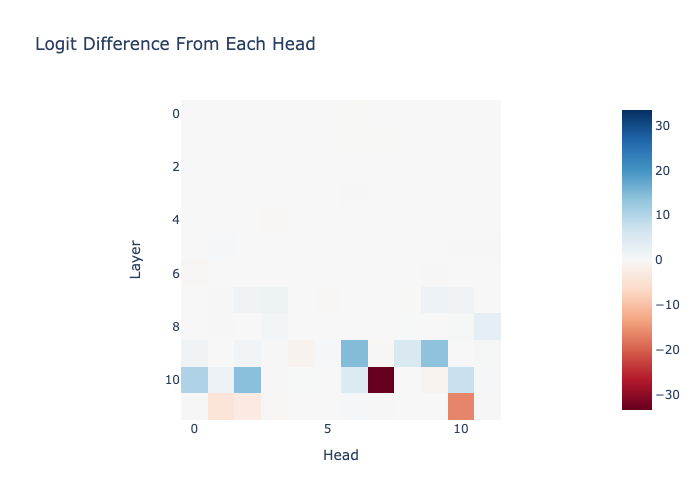

In [4]:
_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts
plot_head_contribution(cache)

In [5]:
for layer in range(model.cfg.n_layers):
    resid_stream = cache['resid_post', layer][0]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)
    logits = model.unembed(resid_stream)
    pred_token = logits[:, -1, :].argmax(-1)
    pred = model.tokenizer.decode(pred_token)
    print(f'Layer {layer}: {prompts[0][0]} ...{pred[:5]}')

Layer 0:  Mary was older than John. Who was born first? Mary was born before ... suns
Layer 1:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 2:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 3:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 4:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 5:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 6:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 7:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 8:  Mary was older than John. Who was born first? Mary was born before ... the 
Layer 9:  Mary was older than John. Who was born first? Mary was born before ... John
Layer 10:  Mary was older than John. Who was born first? Mary was born before ... John
Layer 11:  Mary was older than John. Who was born fir

In [6]:
per_head_logit_diffs = calculate_head_contribution(cache)
heads = torch.topk(per_head_logit_diffs.flatten(), k=16).indices
HTML(visualize_attention_patterns(heads, cache, prompts))

In [7]:
neg_heads = torch.topk(-per_head_logit_diffs.flatten(), k=16).indices
HTML(visualize_attention_patterns(neg_heads, cache, prompts))

### Corrupted inputs

Now generate prompts, but with the names reversed so the IOI now contradicts the information in the context - e.g.

> Alice was older than Mary. Who was born first? Mary was born before ...

In [8]:
corrupted_prompts = generate_prompts(
    "{2} was older than{3}. Who was born first?{3} was born before"
)
corrupted_prompts[:5]

[(' Mary was older than John. Who was born first? John was born before',
  (' John', ' Mary')),
 (' Mary was older than Alice. Who was born first? Alice was born before',
  (' Alice', ' Mary')),
 (' John was older than Mary. Who was born first? Mary was born before',
  (' Mary', ' John')),
 (' John was older than Alice. Who was born first? Alice was born before',
  (' Alice', ' John')),
 (' Alice was older than Mary. Who was born first? Mary was born before',
  (' Mary', ' Alice'))]

Tried to stack head results when they weren't cached. Computing head results now


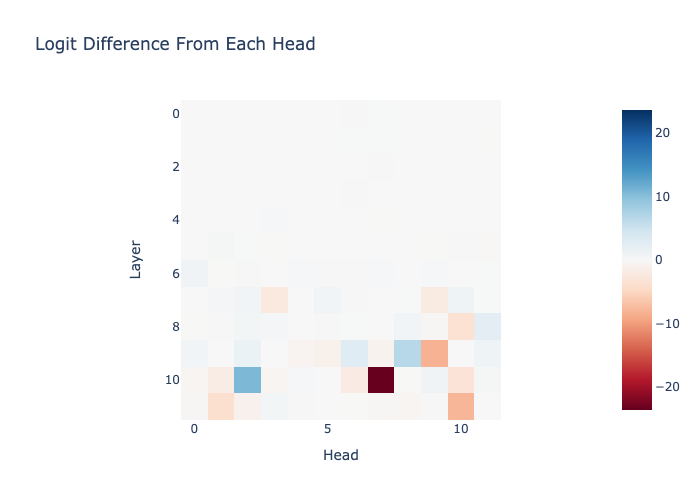

In [9]:
_, corrupted_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

plot_head_contribution(corrupted_cache)

Head contributions are mostly the same, but interestingly some of the top negative contributions for the truthful case are positive contributions here and vice-versa. E.g. 9.9 and 10.10

In [10]:
for layer in range(model.cfg.n_layers):
    resid_stream = corrupted_cache['resid_post', layer][0]
    resid_stream = corrupted_cache.apply_ln_to_stack(resid_stream, layer)
    logits = model.unembed(resid_stream)
    pred_token = logits[:, -1, :].argmax(-1)
    pred = model.tokenizer.decode(pred_token)
    print(f'Layer {layer}: {corrupted_prompts[0][0]} ...{pred[:5]}')

Layer 0:  Mary was older than John. Who was born first? John was born before ... suns
Layer 1:  Mary was older than John. Who was born first? John was born before ... the 
Layer 2:  Mary was older than John. Who was born first? John was born before ... the 
Layer 3:  Mary was older than John. Who was born first? John was born before ... the 
Layer 4:  Mary was older than John. Who was born first? John was born before ... the 
Layer 5:  Mary was older than John. Who was born first? John was born before ... the 
Layer 6:  Mary was older than John. Who was born first? John was born before ... the 
Layer 7:  Mary was older than John. Who was born first? John was born before ... the 
Layer 8:  Mary was older than John. Who was born first? John was born before ... the 
Layer 9:  Mary was older than John. Who was born first? John was born before ... Mary
Layer 10:  Mary was older than John. Who was born first? John was born before ... Mary
Layer 11:  Mary was older than John. Who was born fir

In [11]:
corrupted_per_head_logit_diffs = calculate_head_contribution(corrupted_cache)
corrupted_heads = torch.topk(corrupted_per_head_logit_diffs.flatten(), k=16).indices
HTML(visualize_attention_patterns(corrupted_heads, corrupted_cache, corrupted_prompts))

In [12]:
neg_corrupted_heads = torch.topk(-corrupted_per_head_logit_diffs.flatten(), k=16).indices
HTML(visualize_attention_patterns(neg_corrupted_heads, corrupted_cache, corrupted_prompts))

### Interesting early heads

These heads standout when looking at the attention patterns because they show a clear difference between the true and false cases. For true statements the heads attend to the tokens representing the information in the previous sentence, but for false statements they attend to the period token.

In [13]:
indices = [
    (5, 5),
    (6, 9),
]

indices = [
    (i * model.cfg.n_heads + j)
    for i, j in indices
]

In [14]:
HTML(visualize_attention_patterns(indices, cache, prompts))

In [15]:
HTML(visualize_attention_patterns(indices, corrupted_cache, corrupted_prompts))